In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import numpy as np

import pickle 
import time
import copy
from PIL import Image

import torch
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader

from numpy import random

import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tf
import albumentations as albu

In [3]:
def MinMaxNormalization(image,vmin=0, vmax=1):
        arr = np.array(image).astype('float32')
        arr = (arr - arr.min()) / (arr.max() - arr.min())
        arr = (vmax - vmin) * arr + vmin
        return arr

In [4]:
class SeismicDataset(Dataset):
    def __init__(self, train_dir, mask_dir,augmentation=None,preprocessing=None):
        """
        Constructor of the dataset.
        """
        Dataset.__init__(self)
        self.train_dir = train_dir
        self.mask_dir = mask_dir
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        
    def __len__(self):
        """
        Get the number of samples in the dataset.
        """
        return self.train_dir.shape[0]


    def __getitem__(self, idx):
        """
        Get an item from the dataset.
        """
        # load image
        image_path = self.train_dir.iloc[idx]['path']
        image = Image.open(image_path)
        image = np.array(image)[...,:3]
        
        # load mask
        mask_path = self.mask_dir.iloc[idx]['path']
        mask = Image.open(mask_path)
        mask = np.array(mask)
        
        masks = [(mask == v) for v in range(1,7)]
        mask = np.stack(masks, axis=-1).astype('float')
                
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
                
        return image,mask

In [5]:
train_dir = pd.read_csv('train_image.csv',index_col=0)
mask_dir = pd.read_csv('train_mask.csv',index_col=0)

In [6]:
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_val = train_dir.loc[:int(len(train_dir)*0.8)], train_dir.loc[int(len(train_dir)*0.8):]

y_train, y_val = mask_dir.loc[:int(len(mask_dir)*0.8)], mask_dir.loc[int(len(mask_dir)*0.8):]

In [17]:
dataset = SeismicDataset(train_dir=X_train,
                        mask_dir=y_train,
                        )

In [18]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(10, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

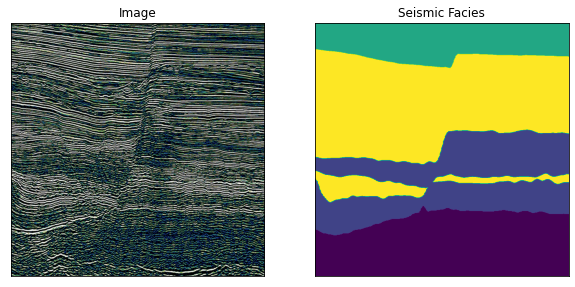

In [19]:
image, mask = dataset[0]
visualize(
    image=image, 
    seismic_facies=np.argmax(mask,axis=2)+1,
)

In [20]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)

In [21]:
def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)

In [22]:
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

In [23]:
def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

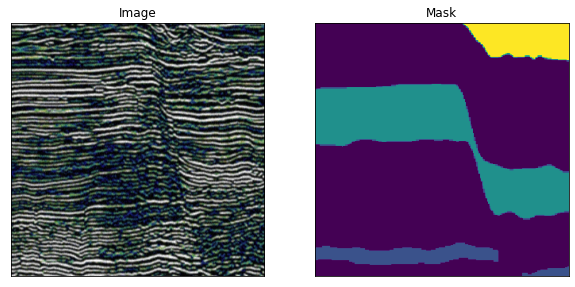

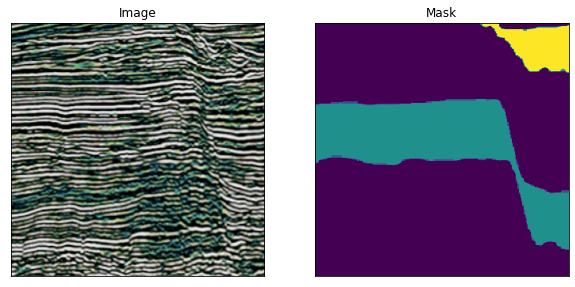

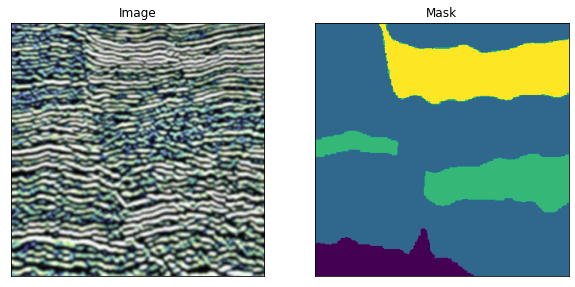

In [24]:
augmented_dataset = SeismicDataset(
            train_dir=X_train,
            mask_dir=y_train,         
            augmentation=get_training_augmentation(),
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[1]
    visualize(image=image, mask=np.argmax(mask,axis=2)+1)

### Create and train the model 

In [25]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [26]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = 6
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=CLASSES, 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [27]:
train_dataset = SeismicDataset(
    train_dir=X_train,
    mask_dir=y_train,         
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
)

valid_dataset = SeismicDataset(
    train_dir=X_val,
    mask_dir=y_val,         
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)

C:\Users\nilso\Anaconda3\lib\site-packages\albumentations\augmentations\transforms.py:2908: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  "Using lambda is incompatible with multiprocessing. "


In [28]:
inputs, masks = next(iter(train_loader))

In [29]:
inputs[0].shape

torch.Size([3, 320, 320])

In [30]:
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [31]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [32]:
max_score = 0

for i in range(0, 20):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')


Epoch: 0
train:   0%|                                                                                   | 0/313 [00:01<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 2.00 GiB total capacity; 532.02 MiB already allocated; 0 bytes free; 574.00 MiB reserved in total by PyTorch)

In [24]:
# load best saved checkpoint
best_model = torch.load('./best_model.pth')

In [25]:
test_dataset = SeismicDataset(
    X_val, 
    y_val, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


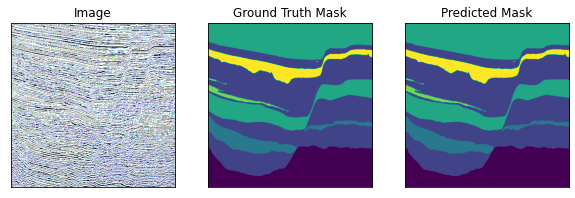

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


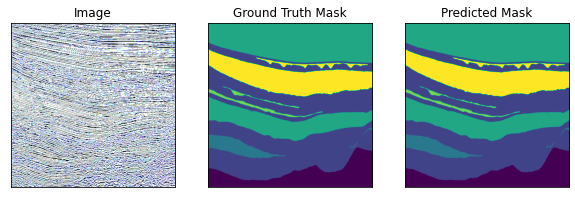

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


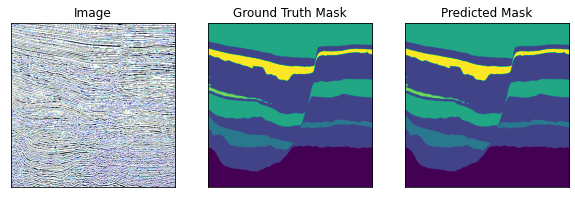

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


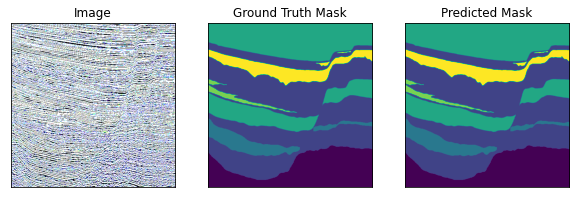

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


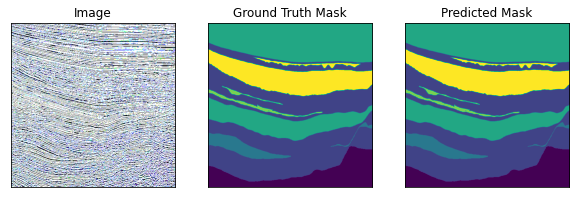

In [30]:
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image.transpose(1, 2, 0), 
        ground_truth_mask=np.argmax(gt_mask,axis=0), 
        predicted_mask=np.argmax(gt_mask,axis=0)
    )

In [60]:
test_dir = pd.read_csv('test_image.csv',index_col=0)

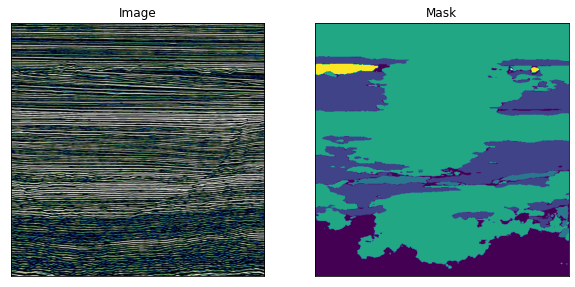

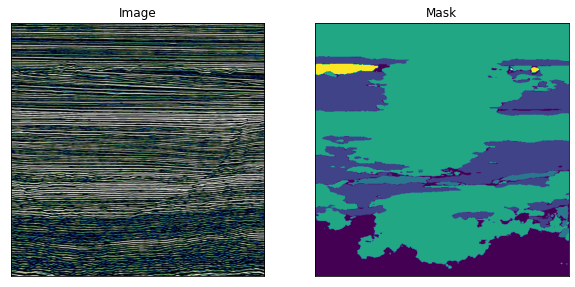

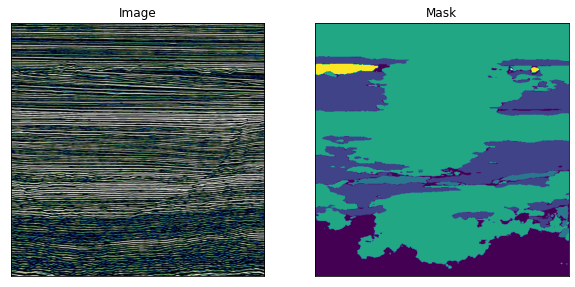

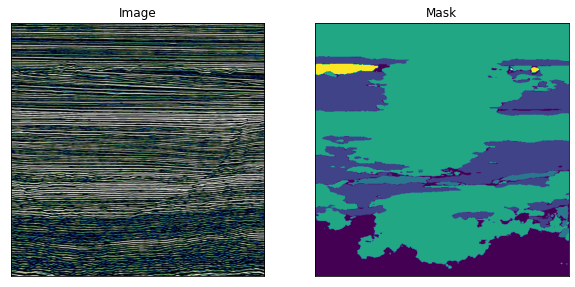

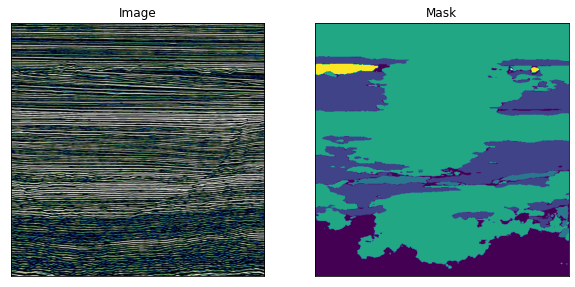

In [219]:
for i in range(5):
    n = np.random.choice(len(test_dir))
    
    image_path = test_dir.iloc[1]['path']
    image = Image.open(image_path)
    image = np.array(image)[...,:3]

    x_tensor = torch.from_numpy(image.transpose(2, 0, 1).astype('float32')).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image, 
        mask = np.argmax(pr_mask,axis=0)+1
    )

In [189]:
final_preds = np.zeros((1006,782,251))

In [191]:
for i in range(len(test_dir)):
    image_path = test_dir.iloc[i]['path']
    image = Image.open(image_path)
    image = np.array(image)[...,:3]

    x_tensor = torch.from_numpy(image.transpose(2, 0, 1).astype('float32')).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    im = Image.fromarray(np.int8(np.argmax(pr_mask,axis=0)+1)).resize((251,1006))
    
    final_preds[:,i,:] = np.array(im)

In [198]:
np.savez_compressed('submission.npz', prediction = final_preds)

### Test

In [ ]:
import torch
import torch.nn as nn

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   


class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
                
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

In [ ]:
device = torch.device('cpu')

model = UNet(6)
model = model.to(device)

In [ ]:
import torch
import torch.nn as nn

def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()

In [ ]:
from collections import defaultdict
import torch.nn.functional as F

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
        
    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)
    
    loss = bce * bce_weight + dice * (1 - bce_weight)
    
    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))    

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)             

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.no_grad():
                    outputs = model(inputs)
                    labels = labels.type(torch.FloatTensor)
                    loss = calc_loss(outputs, labels, metrics)
                    print(loss)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 7

model = UNet(num_class).to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=25, gamma=0.1)

model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=40)